In [ ]:
!git clone https://gitlab.com/ykristian/indonesian-trafic-sign-dataset.git/

Cloning into 'indonesian-trafic-sign-dataset'...
remote: Enumerating objects: 17, done.
remote: Total 17 (delta 0), reused 0 (delta 0), pack-reused 17
Unpacking objects: 100% (17/17), done.
Checking out files: 100% (6/6), done.


In [ ]:
!ls

indonesian-trafic-sign-dataset	sample_data


In [ ]:
!ls indonesian-trafic-sign-dataset

DatasetDetection.csv		       DatasetSignClassification-11Class.p
DatasetDetection.p		       DatasetSignClassification-44Class.csv
DatasetSignClassification-11Class.csv  DatasetSignClassification-44Class.p


# Import libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pickle #we use pickle to convert our image dataset to a single file and need it to read pickle file
import pandas as pd 
import random
import requests
import cv2 #open CV
from PIL import Image #Python Imaging Library (Pillow)

from sklearn.model_selection import train_test_split #to split our dataset

#For our Neural Net we will use Keras with Tensorflow Backend
import keras
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from keras.utils.np_utils import to_categorical #you can also use pandas get_dummies 
from keras.layers import Dropout, Flatten 
from keras.layers.convolutional import Conv2D, MaxPooling2D

np.random.seed(1010)

In [ ]:
with open("indonesian-trafic-sign-dataset/DatasetDetection.p", "rb") as f:
  data = pickle.load(f)

# Simple plot of one image

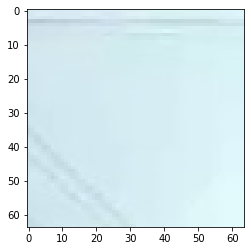

In [ ]:
plt.imshow(data["train_data"][1])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data["train_data"], 
                                   data["label_data"], test_size=0.2, random_state=101)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                   test_size=0.15, random_state=101)

print("X_train Shape:", X_train.shape)
print("X_val Shape:",X_val.shape)
print("X_test Shape:",X_test.shape)

print("y_train Shape:", y_train.shape)
print("y_val Shape:",y_val.shape)
print("y_test Shape:",y_test.shape)

X_train Shape: (13917, 64, 64, 3)
X_val Shape: (2457, 64, 64, 3)
X_test Shape: (4094, 64, 64, 3)
y_train Shape: (13917,)
y_val Shape: (2457,)
y_test Shape: (4094,)


In [ ]:
dataCSV = pd.read_csv("indonesian-trafic-sign-dataset/DatasetDetection.csv")
dataCSV

,ClassID,RambuOrNot
0,0,Non Rambu
1,1,Rambu


[10991, 2926]


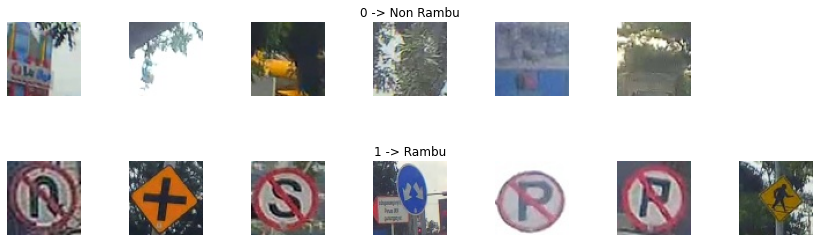

In [ ]:
num_of_samples = [] #counting the number of sample for each class
 
cols = 7 #number of col to display
num_classes =2 #number of class
 
fig, axs = plt.subplots(nrows=num_classes, ncols = cols, figsize=(12, 4)) #setting up matplotlib 
fig.tight_layout()
for i in range(cols): #for every col
    for j, row in dataCSV.iterrows(): #for every class
        x_selected = X_train[y_train == j] #select only X that have current j label
        axs[j][i].imshow(x_selected[random.randint(0, len(x_selected - 1)), :, :], cmap="gray") #randomly show X
        axs[j][i].axis("off")
        if i == 3: #for the midle col
            axs[j][i].set_title(str(j) + " -> " + row["RambuOrNot"]) #print class name
            num_of_samples.append(len(x_selected)) #register the sample count
            
print(num_of_samples)

Preprocessing

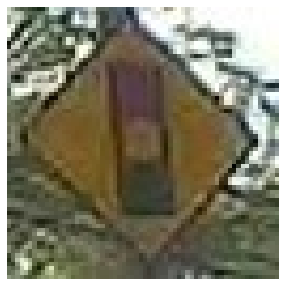

In [ ]:
def tampil(img):
  plt.figure(figsize=(5,5))
  plt.axis("off")
  plt.imshow(img,cmap="gray")
  
random_index = random.randint(9000,10000)
tampil(X_train[random_index])

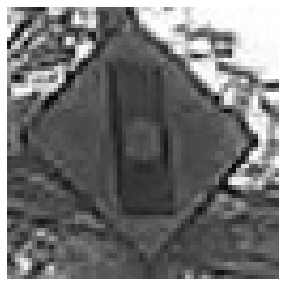

In [ ]:
def grayscale(img):
  img1 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  return img1

gray = grayscale(X_train[random_index])
tampil(gray)

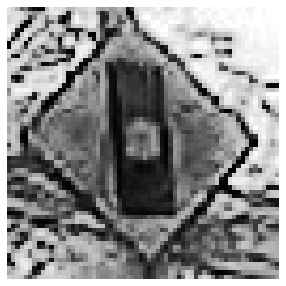

In [ ]:
def equalize(img):
  img1 = cv2.equalizeHist(img)
  return img1

eq = equalize(gray)
tampil(eq)

In [ ]:
def preprocessing(img):
  gray = grayscale(img)
  eq = equalize(gray)
  norm = eq/255
  return norm

new_X_train=[]
for i in range(X_train.shape[0]):
  new_X_train.append(preprocessing(X_train[i]))  
X_train = np.array(new_X_train)

new_X_val=[]
for i in range(X_val.shape[0]):
  new_X_val.append(preprocessing(X_val[i]))  
X_val = np.array(new_X_val)

new_X_test=[]
for i in range(X_test.shape[0]):
  new_X_test.append(preprocessing(X_test[i]))  
X_test = np.array(new_X_test)

In [ ]:
y_train = pd.get_dummies(y_train)
y_test = pd.get_dummies(y_test)
y_val = pd.get_dummies(y_val)

print("y_train Shape:", y_train.shape)
print("y_val Shape:",y_val.shape)
print("y_test Shape:",y_test.shape)

y_train Shape: (13917, 2)
y_val Shape: (2457, 2)
y_test Shape: (4094, 2)


In [ ]:
print("X_train Shape:", X_train.shape)
print("X_val Shape:",X_val.shape)
print("X_test Shape:",X_test.shape)

#add a dept dimension to all of our X
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], X_val.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

print("X_train Shape:", X_train.shape)
print("X_val Shape:",X_val.shape)
print("X_test Shape:",X_test.shape)

X_train Shape: (13917, 64, 64)
X_val Shape: (2457, 64, 64)
X_test Shape: (4094, 64, 64)
X_train Shape: (13917, 64, 64, 1)
X_val Shape: (2457, 64, 64, 1)
X_test Shape: (4094, 64, 64, 1)


Neural Network

In [ ]:
def Conv_Net_model():
  model = Sequential()
  model.add(Conv2D(100,(3,3), input_shape=(64,64,1), activation="relu"))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Conv2D(120,(5,5), activation="relu"))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Conv2D(140,(3,3), activation="relu"))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(rate=0.5))
  model.add(Flatten())
  model.add(Dense(200, activation="relu"))
  model.add(Dropout(rate=0.5))
  model.add(Dense(100, activation="relu"))
  model.add(Dropout(rate=0.5))
  model.add(Dense(num_classes, activation="softmax"))
  model.compile(Adam(lr=0.001), loss = "categorical_crossentropy", metrics = ["accuracy"])
  return model

model = Conv_Net_model()
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 100)       1000      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 100)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 120)       300120    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 13, 13, 120)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 11, 11, 140)       151340    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 5, 5, 140)        0

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
h = model.fit(X_train, y_train, epochs=20, validation_data = (X_val, y_val), 
                batch_size=400, verbose=1, shuffle=1)

Epoch 1/20
35/35 [==============================] - 528s 15s/step - loss: 0.5206 - accuracy: 0.7800 - val_loss: 0.4426 - val_accuracy: 0.7932
Epoch 2/20
35/35 [==============================] - 514s 15s/step - loss: 0.4102 - accuracy: 0.8102 - val_loss: 0.3340 - val_accuracy: 0.8608
Epoch 3/20
35/35 [==============================] - 509s 15s/step - loss: 0.3140 - accuracy: 0.8701 - val_loss: 0.2661 - val_accuracy: 0.8917
Epoch 4/20
35/35 [==============================] - 512s 15s/step - loss: 0.2468 - accuracy: 0.9040 - val_loss: 0.1983 - val_accuracy: 0.9178
Epoch 5/20
35/35 [==============================] - 509s 15s/step - loss: 0.2176 - accuracy: 0.9178 - val_loss: 0.1807 - val_accuracy: 0.9276
Epoch 6/20
35/35 [==============================] - 514s 15s/step - loss: 0.1801 - accuracy: 0.9303 - val_loss: 0.1490 - val_accuracy: 0.9442
Epoch 7/20
35/35 [==============================] - 513s 15s/step - loss: 0.1736 - accuracy: 0.9356 - val_loss: 0.1367 - val_accuracy: 0.9442
Epoch 

Text(0.5, 1.0, 'Loss')

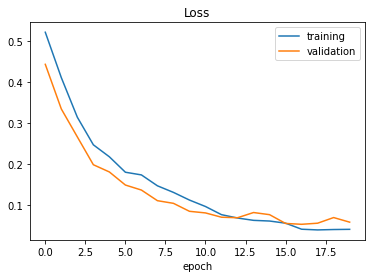

In [ ]:
plt.plot(h.history["loss"])
plt.plot(h.history["val_loss"])
plt.legend(["training","validation"])
plt.xlabel("epoch")
plt.title("Loss")

Text(0.5, 1.0, 'Accuracy')

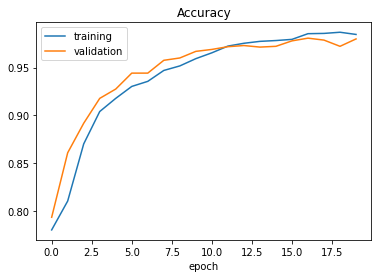

In [ ]:
plt.plot(h.history["accuracy"])
plt.plot(h.history["val_accuracy"])
plt.legend(["training","validation"])
plt.xlabel("epoch")
plt.title("Accuracy")

In [ ]:
score = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy = ", score[1])

Accuracy =  0.9772838354110718


Real Life Test

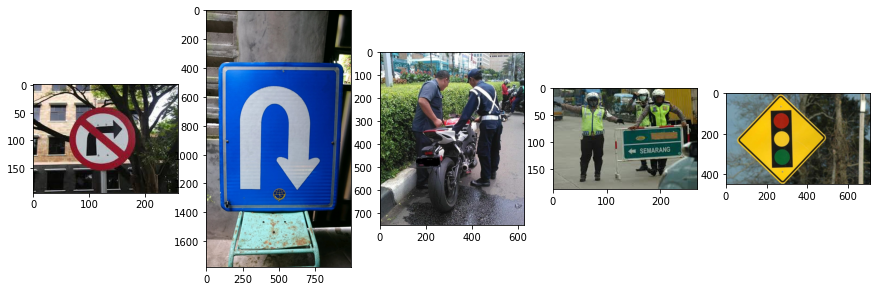

(5, 64, 64, 3)


In [ ]:
urls=[]
urls.append("https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSvR1kc8ul61KfpKP7TtuF9TtXhC7E_vi3O_3H4RkM-UvvaGn1U")
urls.append("https://s2.bukalapak.com/img/2205643702/w-1000/Rambu_Marka_Jalan_Petunjuk_Turnback_Putar_Balik_.png")
urls.append("https://i2.wp.com/kobayogas.com/wp-content/uploads/2016/12/cbr1000rr-irfan-farhan-motovlogger-kecelakaan-1-e1481808673273.jpg?resize=626%2C753")
urls.append("https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQqtwfth7Js9DWvtxdvSxFI0gKZO1d_xLqntuChTOf0X5OJEDujwA")
urls.append("https://i0.wp.com/www.ngehits.net/wp-content/uploads/2016/03/lampu-lalu-lintas.jpg?resize=710%2C448")


imgs=[]
plt.figure(figsize=(15,6))
for u in range(0,len(urls)):
  r = requests.get(urls[u], stream=True)
  img = np.array(Image.open(r.raw))
  plt.subplot(1,len(urls),u+1)
  plt.imshow(img)
  #resize to same size before appending to imgs so we can maintain np array dimension
  img = cv2.resize(img, (64,64))
  imgs.append(img)
plt.show()

imgs = np.array(imgs)
print (imgs.shape)

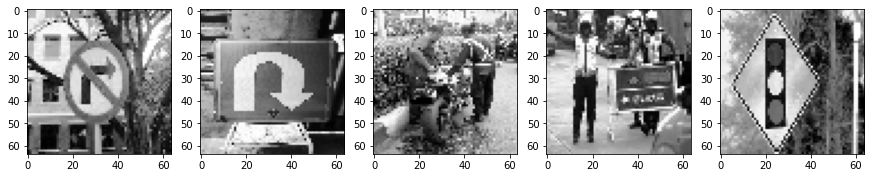

In [ ]:
grays=[]
plt.figure(figsize=(15,6))
for u in range(0,imgs.shape[0]):
  plt.subplot(1,imgs.shape[0],u+1)
  grays.append(preprocessing(imgs[u]))
  plt.imshow(grays[u], cmap="gray")
  grays[u] = grays[u].reshape(64,64,1)
plt.show()
grays = np.array(grays)

In [ ]:
y_pred = (model.predict(grays) > 0.5).astype("int32")
print(y_pred)
raw = dataCSV.to_numpy()

[[0 1]
 [0 1]
 [1 0]
 [1 0]
 [0 1]]
